# From experiments 1, 2 and 3

In [7]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as F
from torchvision.models import inception_v3, Inception_V3_Weights

import os
import glob
from PIL import Image
import torch
import torchvision.transforms as T
import matplotlib.pyplot as plt
import numpy as np

In [8]:
image_w = 1920
image_h = 1080
dummy_img = torch.zeros(1, 3, image_h, image_w).float()

In [9]:
class InceptionFeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        model = inception_v3(weights=Inception_V3_Weights.DEFAULT, transform_input=True)
        self.feature_extractor = nn.Sequential(
            model.Conv2d_1a_3x3,
            model.Conv2d_2a_3x3,
            model.Conv2d_2b_3x3,
            model.maxpool1,
            model.Conv2d_3b_1x1,
            model.Conv2d_4a_3x3,
            model.maxpool2,
            model.Mixed_5b,
            model.Mixed_5c,
            model.Mixed_5d,
            model.Mixed_6a,
            model.Mixed_6b,
            model.Mixed_6c,
            model.Mixed_6d,
            model.Mixed_6e,
            model.Mixed_7a, 
            model.Mixed_7b, 
            model.Mixed_7c
        )
        
    def forward(self, x):
        return self.feature_extractor(x)
    
feature_extractor = InceptionFeatureExtractor()
feature_extractor.eval() 
out_dummy_img = feature_extractor(dummy_img)
print(f"Output shape: {out_dummy_img.shape}")
print(f"Number of channels: {out_dummy_img.shape[1]}")
print(f"Spatial dimensions: {out_dummy_img.shape[2]}x{out_dummy_img.shape[3]}")

Output shape: torch.Size([1, 2048, 32, 58])
Number of channels: 2048
Spatial dimensions: 32x58


In [10]:
def visualize_features(feature_extractor, image_dir = '../soccernet_data/tracking/train/SNMOT-060/img1'):
    
    if not os.path.exists(image_dir):
        print(f"Directory {image_dir} does not exist.")

    image_files = sorted(glob.glob(os.path.join(image_dir, '*.jpg')))
    sample_images = image_files[:3]

    image_net_mean = [0.485, 0.456, 0.406]
    image_net_std=[0.229, 0.224, 0.225]
    sample_images = image_files[:3]  
        
    transform = T.Compose([
        T.ToTensor(),
        T.Normalize(mean=image_net_mean, std=image_net_std)
    ])

    for img_path in sample_images:

        img = Image.open(img_path).convert('RGB')
        img_w, img_h = img.size
        img_tensor = transform(img).unsqueeze(0)  

        with torch.no_grad():
            features = feature_extractor(img_tensor)

        print(f"Image: {os.path.basename(img_path)}")
        print(f"Original image dimensions: {img_w}x{img_h}")
        print(f"Feature map shape: {features.shape}")

        plt.figure(figsize=(10, 5.625))
        plt.subplot(1, 2, 1)
        plt.imshow(img)
        plt.title("Original Image")
        plt.axis('off')

        plt.subplot(1, 2, 2)
        feature_map = features[0].sum(dim=0).cpu().numpy()
        plt.imshow(feature_map, cmap='viridis')
        plt.title(f"Feature Map (Sum of {features.shape[1]} channels)")
        plt.axis('off')

        plt.tight_layout()
        plt.show()

In [11]:
def generate_base_anchors(scales, aspect_ratios, downsampling_factor_h, downsampling_factor_w):
    ctr_y = downsampling_factor_h / 2.0
    ctr_x = downsampling_factor_w / 2.0
    num_anchors = len(scales) * len(aspect_ratios)
    base_anchors = np.zeros((num_anchors, 4), dtype=np.float32)

    index = 0
    for scale in scales:
        for ar in aspect_ratios:
            h = downsampling_factor_h * scale * np.sqrt(ar)
            w = downsampling_factor_w * scale * np.sqrt(1.0 / ar)
            base_anchors[index, 0] = ctr_y - h / 2.0
            base_anchors[index, 1] = ctr_x - w / 2.0
            base_anchors[index, 2] = ctr_y + h / 2.0
            base_anchors[index, 3] = ctr_x + w / 2.0
            
            index += 1
            
    return base_anchors



def generate_anchor_boxes(feature_map_size, base_anchors, downsampling_factor_h, downsampling_factor_w):
    height, width = feature_map_size
    shift_y = np.arange(0, height) * downsampling_factor_h
    shift_x = np.arange(0, width) * downsampling_factor_w
    shift_x, shift_y = np.meshgrid(shift_x, shift_y)
    
    shifts = np.vstack((
        shift_y.ravel(), shift_x.ravel(),
        shift_y.ravel(), shift_x.ravel()
    )).transpose()
    
    A = base_anchors.shape[0]  
    K = shifts.shape[0]  
    all_anchors = base_anchors.reshape((1, A, 4)) + shifts.reshape((K, 1, 4))
    all_anchors = all_anchors.reshape((K * A, 4))
    
    return all_anchors


def visualize_anchor_centers(image_tensor, feature_map_size, downsampling_factor_h, downsampling_factor_w):
    # With batch dimension
    if image_tensor.dim() == 4: 
      img_h, img_w = image_tensor.shape[2], image_tensor.shape[3]
      img_display = image_tensor.squeeze(0) # Remove batch dim for display
    # Without batch dimension
    elif image_tensor.dim() == 3:
      img_h, img_w = image_tensor.shape[1], image_tensor.shape[2]
      img_display = image_tensor
    

    aspect_ratio = img_w / img_h
    height, width = feature_map_size
    img = img_display.permute(1, 2, 0).cpu().numpy()
    img_min, img_max = img.min(), img.max()
    if img_max > img_min: 
        img = (img - img_min) / (img_max - img_min)

    fig_width = 10 
    fig_height = fig_width / aspect_ratio
    plt.figure(figsize=(fig_width, fig_height))

    ax = plt.gca()
    ax.imshow(img, extent=(0, img_w, img_h, 0))
    center_y = np.arange(0, height) * downsampling_factor_h + downsampling_factor_h / 2.0
    center_x = np.arange(0, width) * downsampling_factor_w + downsampling_factor_w / 2.0
    center_x, center_y = np.meshgrid(center_x, center_y)
    
    ax.scatter(center_x, center_y, c='b', s=10, alpha=0.6, marker='o') 
    ax.set_title(f'Anchor centers ({height}x{width}) mapped to image space')
    ax.set_xlim(0, img_w)
    ax.set_ylim(img_h, 0)
    ax.set_xlabel("Width (pixels)")
    ax.set_ylabel("Height (pixels)")
    ax.set_aspect('equal', adjustable='box')
    
    plt.tight_layout() 
    plt.show()

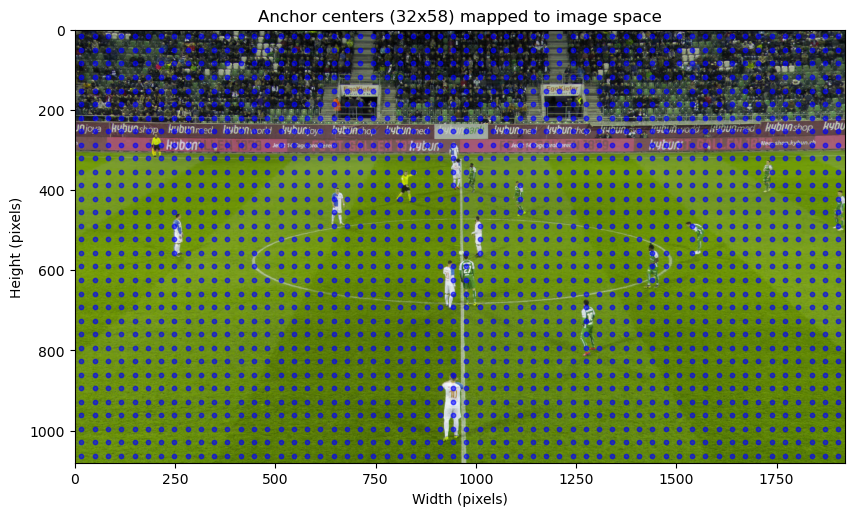

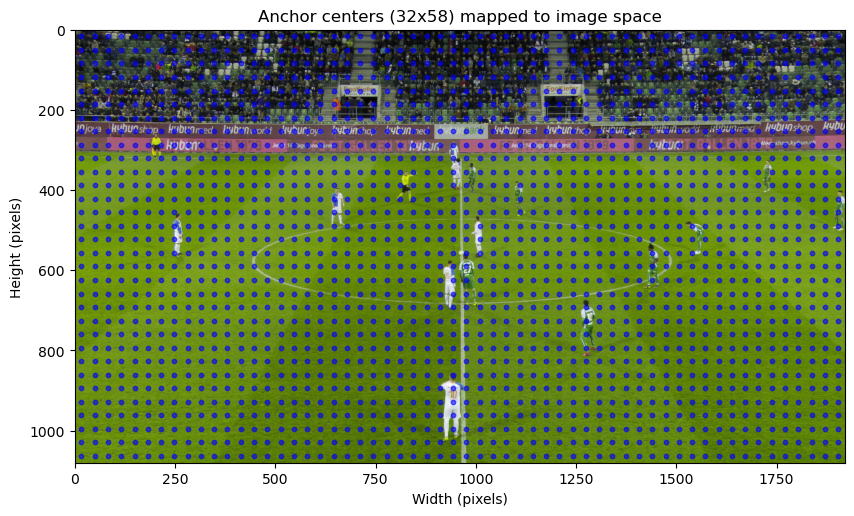

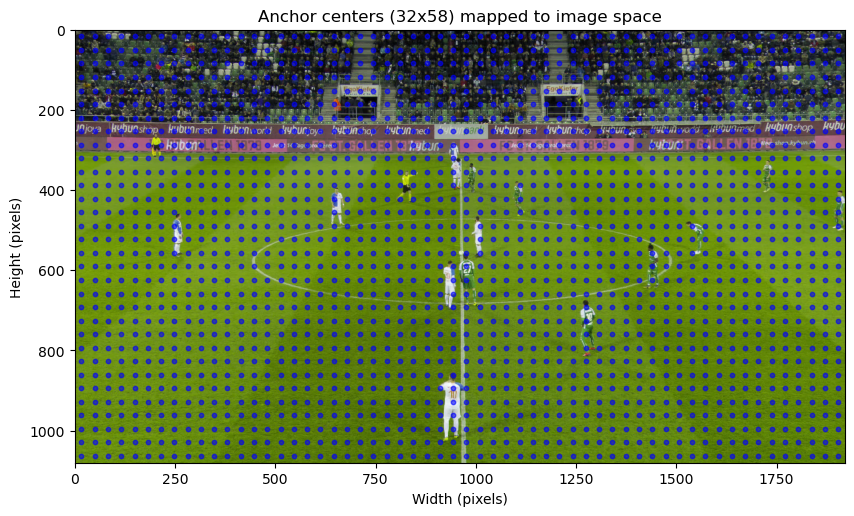

In [12]:

def visualize_anchors_on_sample_images(feature_extractor, image_dir='../soccernet_data/tracking/train/SNMOT-060/img1'):
    if not os.path.exists(image_dir):
        print(f"Directory {image_dir} does not exist.")
        return
    
    image_files = sorted(glob.glob(os.path.join(image_dir, '*.jpg')))
    sample_images = image_files[:3]
    
    image_net_mean = [0.485, 0.456, 0.406]
    image_net_std = [0.229, 0.224, 0.225]
    
    transform = T.Compose([
        T.ToTensor(),
        T.Normalize(mean=image_net_mean, std=image_net_std)
    ])
    
    for img_path in sample_images:
        img = Image.open(img_path).convert('RGB')
        img_w, img_h = img.size
        img_tensor = transform(img).unsqueeze(0)
        
        feature_extractor.eval()
        with torch.no_grad():
            features = feature_extractor(img_tensor)
        
        feature_map_height = features.shape[2]
        feature_map_width = features.shape[3]
        
        downsampling_factor_h = img_h / feature_map_height
        downsampling_factor_w = img_w / feature_map_width
        
        scales = [8, 16, 32]
        aspect_ratios = [0.5, 1.0, 2.0]
        base_anchors = generate_base_anchors(scales, aspect_ratios, downsampling_factor_h, downsampling_factor_w)
        anchors = generate_anchor_boxes(
            (feature_map_height, feature_map_width),
            base_anchors,
            downsampling_factor_h,
            downsampling_factor_w
        )
        
        plt.figure(figsize=(10, 5.625))
        ax = plt.gca()
        ax.imshow(np.array(img), extent=(0, img_w, img_h, 0))
        
        center_y = np.arange(0, feature_map_height) * downsampling_factor_h + downsampling_factor_h / 2.0
        center_x = np.arange(0, feature_map_width) * downsampling_factor_w + downsampling_factor_w / 2.0
        center_x, center_y = np.meshgrid(center_x, center_y)
        
        ax.scatter(center_x, center_y, c='b', s=10, alpha=0.6, marker='o')
        ax.set_title(f'Anchor centers ({feature_map_height}x{feature_map_width}) mapped to image space')
        ax.set_xlim(0, img_w)
        ax.set_ylim(img_h, 0)
        ax.set_xlabel("Width (pixels)")
        ax.set_ylabel("Height (pixels)")
        ax.set_aspect('equal', adjustable='box')
        
        plt.show()
        
    

visualize_anchors_on_sample_images(feature_extractor)

# Experiment 4

In [13]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

# --- (from Exp2) anchor‐generation routines ---

def generate_base_anchors(scales, aspect_ratios, down_h, down_w):
    ctr_y, ctr_x = down_h/2.0, down_w/2.0
    A = len(scales) * len(aspect_ratios)
    base = np.zeros((A,4), dtype=np.float32)
    idx = 0
    for s in scales:
        for ar in aspect_ratios:
            h = down_h * s * np.sqrt(ar)
            w = down_w * s * np.sqrt(1/ar)
            base[idx,0] = ctr_y - h/2.0  # y_min
            base[idx,1] = ctr_x - w/2.0  # x_min
            base[idx,2] = ctr_y + h/2.0  # y_max
            base[idx,3] = ctr_x + w/2.0  # x_max
            idx += 1
    return base

def generate_anchor_boxes(fmap_size, base_anchors, down_h, down_w):
    Hf, Wf = fmap_size
    shift_y = np.arange(0, Hf) * down_h
    shift_x = np.arange(0, Wf) * down_w
    shift_x, shift_y = np.meshgrid(shift_x, shift_y)
    shifts = np.stack([shift_y.ravel(), shift_x.ravel(),
                       shift_y.ravel(), shift_x.ravel()], axis=1)
    K = shifts.shape[0]; A = base_anchors.shape[0]
    all_ = base_anchors.reshape((1,A,4)) + shifts.reshape((K,1,4))
    return all_.reshape((K*A,4))

def compute_iou(boxes1, boxes2):
    # boxes: [ymin, xmin, ymax, xmax]
    N, M = boxes1.shape[0], boxes2.shape[0]
    y1 = np.maximum(boxes1[:,None,0], boxes2[None,:,0])
    x1 = np.maximum(boxes1[:,None,1], boxes2[None,:,1])
    y2 = np.minimum(boxes1[:,None,2], boxes2[None,:,2])
    x2 = np.minimum(boxes1[:,None,3], boxes2[None,:,3])
    h = np.clip(y2 - y1, 0, None)
    w = np.clip(x2 - x1, 0, None)
    inter = h * w
    area1 = (boxes1[:,2]-boxes1[:,0])*(boxes1[:,3]-boxes1[:,1])
    area2 = (boxes2[:,2]-boxes2[:,0])*(boxes2[:,3]-boxes2[:,1])
    union = area1[:,None] + area2[None,:] - inter
    return inter / union






Frame 000001: 51 positives, 284959 negatives found
Frame 000001 positive anchor scales: [3, 3, 4, 4, 4, 3, 4, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 6, 5, 5, 5, 5, 6, 6, 6, 6, 4, 4, 4, 5, 5, 5, 5, 6, 6, 6, 5, 6, 6, 6, 6, 7, 7, 6, 6, 6, 6, 7]
Frame 000001 positive anchor aspect ratios: [2.5, 3, 1.5, 2.0, 2.0, 3, 4, 3, 3.5, 4, 3, 3.5, 4, 1.5, 2.0, 2.5, 3, 3.5, 4, 2.5, 3.5, 2.0, 2.5, 3, 3.5, 2.0, 2.5, 3, 3.5, 3, 3.5, 4, 2.0, 2.5, 3, 3.5, 2.5, 3, 3.5, 3, 2.5, 3, 3.5, 4, 2.5, 3, 2.5, 3, 3.5, 4, 3]
Frame 000001 missed GT indices: [4, 5, 8, 9, 12, 15, 16, 17]
Frame 000001 missed GT actual scales: [np.float64(3.44), np.float64(2.698), np.float64(3.33), np.float64(2.539), np.float64(2.263), np.float64(3.453), np.float64(2.38), np.float64(0.718)]
Frame 000001 missed GT actual aspect ratios: [np.float64(3.367), np.float64(3.522), np.float64(2.606), np.float64(3.409), np.float64(2.478), np.float64(3.893), np.float64(2.32), np.float64(0.917)]


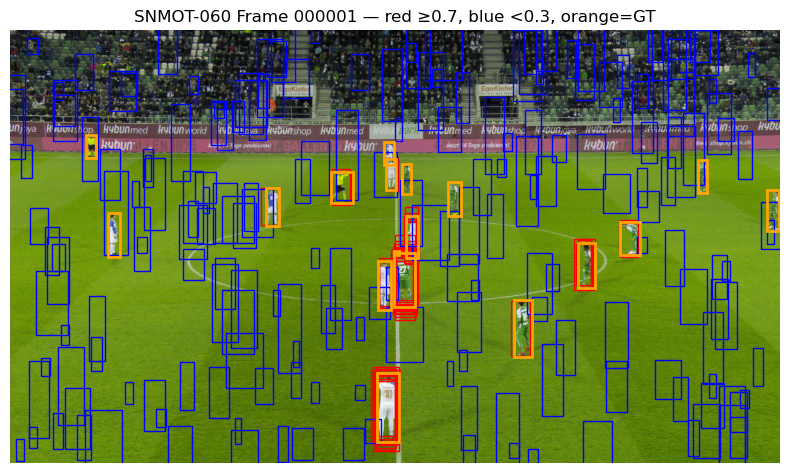

Frame 000002: 58 positives, 284936 negatives found
Frame 000002 positive anchor scales: [3, 3, 3, 4, 4, 4, 3, 4, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 6, 5, 5, 5, 5, 6, 6, 6, 4, 4, 4, 5, 5, 5, 5, 6, 6, 6, 6, 5, 7, 7, 6, 6, 6, 6, 7, 7, 7, 7, 6, 6, 6, 7, 7, 7, 7]
Frame 000002 positive anchor aspect ratios: [2.5, 3, 3.5, 1.5, 2.0, 2.0, 3, 4, 3, 3.5, 4, 3, 3.5, 4, 1.5, 2.0, 2.5, 3, 3.5, 4, 2.5, 3.5, 2.0, 2.5, 3, 3.5, 2.5, 3, 3.5, 3, 3.5, 4, 2.0, 2.5, 3, 3.5, 2.5, 3, 3.5, 3.5, 3, 3, 3.5, 2.0, 2.5, 3, 3.5, 2.0, 2.5, 3, 3.5, 2.0, 2.5, 3, 2.0, 2.5, 3, 3.5]
Frame 000002 missed GT indices: [4, 5, 8, 9, 12, 15, 16, 17]
Frame 000002 missed GT actual scales: [np.float64(3.44), np.float64(2.756), np.float64(3.279), np.float64(2.539), np.float64(2.263), np.float64(3.453), np.float64(2.38), np.float64(0.718)]
Frame 000002 missed GT actual aspect ratios: [np.float64(3.367), np.float64(3.375), np.float64(2.688), np.float64(3.409), np.float64(2.478), np.float64(3.893), np.float64(2.32), np.float64(0.917

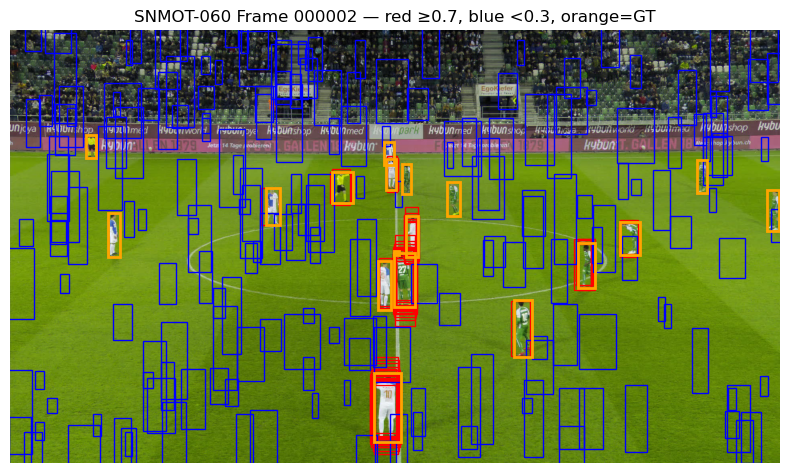

Frame 000003: 54 positives, 284875 negatives found
Frame 000003 positive anchor scales: [3, 3, 3, 4, 4, 4, 4, 4, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 4, 4, 4, 5, 5, 5, 5, 6, 6, 6, 4, 4, 4, 6, 5, 7, 7, 7, 7, 7, 7, 7, 7, 7]
Frame 000003 positive anchor aspect ratios: [2.5, 3, 3.5, 1.5, 1.5, 2.0, 3.5, 4, 3, 3.5, 4, 3, 3.5, 4, 1.5, 2.0, 2.5, 3, 3.5, 4, 2.5, 3, 3, 2.0, 2.5, 3, 3.5, 2.5, 3, 3.5, 3, 3.5, 4, 2.0, 2.5, 3, 3.5, 2.5, 3, 3.5, 3, 3.5, 4, 3.5, 3, 2.5, 1.5, 2.0, 2.5, 3, 1.5, 2.0, 2.5, 3]
Frame 000003 missed GT indices: [4, 5, 8, 9, 12, 15, 16, 17]
Frame 000003 missed GT actual scales: [np.float64(3.44), np.float64(2.868), np.float64(3.227), np.float64(2.539), np.float64(2.263), np.float64(3.453), np.float64(2.38), np.float64(0.718)]
Frame 000003 missed GT actual aspect ratios: [np.float64(3.367), np.float64(3.115), np.float64(2.774), np.float64(3.409), np.float64(2.478), np.float64(3.893), np.float64(2.32), np.float64(0.917)]


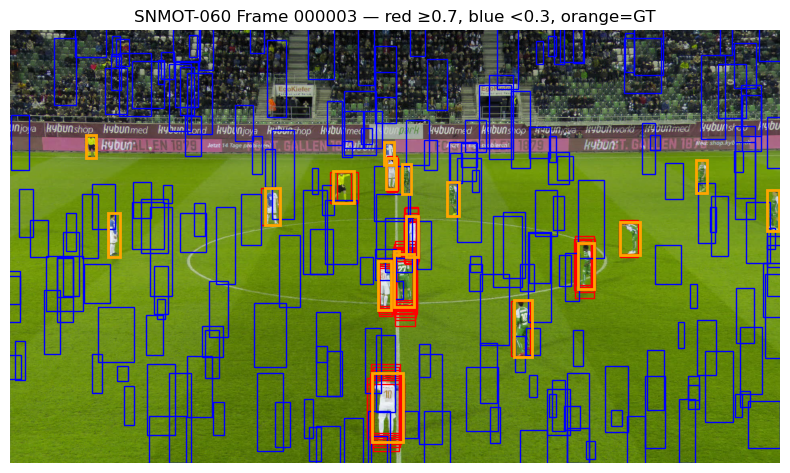

In [ ]:
# --- parameters ---
sequence_id   = "SNMOT-060"
frame_ids     = [1,2,3]
pos_thresh    = 0.7
neg_thresh    = 0.3
# scales        = [2, 4, 8]
scales        = [2, 3, 3.5,4, 5,6, 7]
aspect_ratios = [1.5, 2.0, 2.5, 3, 3.5, 4]

down_h = down_w = 16           # assume backbone stride=16
max_display   = 200           

for fid in frame_ids:
    # load image
    img_path = os.path.join("..","soccernet_data","tracking","train",
                             sequence_id,"img1",f"{fid:06d}.jpg")
    img = np.array(Image.open(img_path))
    H, W = img.shape[:2]

    # make anchors over this image
    fmap_h, fmap_w = H//down_h, W//down_w
    base_anchors = generate_base_anchors(scales, aspect_ratios, down_h, down_w)
    all_anchors  = generate_anchor_boxes((fmap_h, fmap_w),
                                         base_anchors, down_h, down_w)

    # load per-frame GT
    gt_path = os.path.join("..","soccernet_data","tracking","train",
                            sequence_id,"gt-frame",f"{fid:06d}.txt")
    raw = np.loadtxt(gt_path, delimiter=",")
    raw = raw.reshape(-1,5)      # in case only one box
    gt_boxes = raw[:,1:]         # drop track_id, now [ymin, xmin, ymax, xmax]

    # compute IoU and select +ve / -ve
    ious    = compute_iou(all_anchors, gt_boxes)
    max_iou = ious.max(axis=1)
    pos_idx = np.where(max_iou >= pos_thresh)[0]
    neg_idx = np.where(max_iou <  neg_thresh)[0]

    # debug info
    print(f"Frame {fid:06d}: {len(pos_idx)} positives, {len(neg_idx)} negatives found")

    # print scales and aspect ratios for positive anchors
    A = len(scales) * len(aspect_ratios)
    base_indices      = pos_idx % A
    scale_indices     = base_indices // len(aspect_ratios)
    ar_indices        = base_indices % len(aspect_ratios)
    pos_scales        = [scales[i] for i in scale_indices]
    pos_aspect_ratios = [aspect_ratios[j] for j in ar_indices]
    print(f"Frame {fid:06d} positive anchor scales: {pos_scales}")
    print(f"Frame {fid:06d} positive anchor aspect ratios: {pos_aspect_ratios}")

    # compute and print actual scales & aspect ratios for GT boxes with no positive hit
    num_gt   = gt_boxes.shape[0]
    missed_gt = [j for j in range(num_gt) if ious[:, j].max() < pos_thresh]
    if missed_gt:
        actual_scales = []
        actual_ars    = []
        for j in missed_gt:
            y1, x1, y2, x2 = gt_boxes[j]
            h = y2 - y1
            w = x2 - x1
            ar = h / w
            s  = np.sqrt((h * w) / (down_h * down_w))
            actual_scales.append(round(s, 3))
            actual_ars.append(round(ar, 3))
        print(f"Frame {fid:06d} missed GT indices: {missed_gt}")
        print(f"Frame {fid:06d} missed GT actual scales: {actual_scales}")
        print(f"Frame {fid:06d} missed GT actual aspect ratios: {actual_ars}")
    else:
        print(f"Frame {fid:06d} all GT boxes had at least one positive anchor")

    # sample up to max_display for clarity
    if len(pos_idx) > max_display:
        pos_idx = np.random.choice(pos_idx, max_display, replace=False)
    if len(neg_idx) > max_display:
        neg_idx = np.random.choice(neg_idx, max_display, replace=False)

    # plot
    fig, ax = plt.subplots(figsize=(8,8))
    ax.imshow(img)

    # positives in red
    for i in pos_idx:
        y1,x1,y2,x2 = all_anchors[i]
        rect = patches.Rectangle((x1,y1), x2-x1, y2-y1,
                                 linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    # negatives in blue
    for i in neg_idx:
        y1,x1,y2,x2 = all_anchors[i]
        rect = patches.Rectangle((x1,y1), x2-x1, y2-y1,
                                 linewidth=1, edgecolor='b', facecolor='none')
        ax.add_patch(rect)

    # ground-truth in orange
    for (y1, x1, y2, x2) in gt_boxes:
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1,
                                 linewidth=2, edgecolor='orange', facecolor='none')
        ax.add_patch(rect)

    ax.set_title(f"{sequence_id} Frame {fid:06d} — red ≥{pos_thresh}, blue <{neg_thresh}, orange=GT")
    ax.axis('off')
    plt.tight_layout()
    plt.show()
